In [1]:
import argparse
from PIL import Image, ImageDraw, ImageOps, ImageFont
from crisismmd_dataset import clean_text

from torch.utils.data.dataloader import DataLoader
from crisismmd_dataset import CrisisMMDataset, labels_task1, labels_task2

prediction_file = './prediction-task2.csv'
task = 'task2'
num_classes = 2 if task == 'task1' else 8
class Args:
    pass
opt = Args()
opt.load_size = 228
opt.crop_size = 224
opt.max_dataset_size = 2147483648
opt.debug = False

test_set = CrisisMMDataset()
test_set.initialize(opt, phase='test', cat='all',
                    task=task)

label_map = labels_task1 if task == 'task1' else labels_task2
inverse_map = {v: k for k, v in label_map.items()}

[*] 2237 samples loaded.


In [11]:
from torchvision import transforms
from base_dataset import expand2square
transforms = transforms.Compose([
    # transforms.Lambda(lambda img: __scale_shortside(img, opt.load_size, opt.crop_size, Image.BICUBIC)),
    transforms.Lambda(lambda img: expand2square(img)),
    transforms.Resize((opt.load_size, opt.load_size)),
    transforms.RandomCrop(opt.crop_size),
    # transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

for img_idx in range(100, 102):
    
    imgpath = test_set[img_idx]['path_image']
    with Image.open(imgpath) as img:
        img = transforms(img)
        img.show() 


'W:/datasets/CrisisMMD_v2.0/data_image/hurricane_harvey/8_9_2017/905952332923338752_0.jpg'

In [20]:

predictions = open(prediction_file).readlines()

predictions = [int(p) for p in predictions]
import textwrap
def divide(text, length):
    # Devide text into multiple lines if too long
    result = []
    for line in textwrap.wrap(text, width=length):
        result.append(line)
    return "\n".join(result)

output_size = 224
textarea_size = 65

def show(idx, dataset, error_only=False):
    data = dataset[idx]
    if error_only and data['label'] == int(predictions[idx]):
        return
    with Image.open(data['path_image']) as imagePIL:
        
        image = imagePIL.resize((output_size, output_size))

        toShow = Image.new(image.mode, (output_size, output_size+textarea_size), (255, 255, 255))
        toShow.paste(image, (0, textarea_size))

        font = ImageFont.truetype('FONTS/arial.ttf', 9)
        text = clean_text(data['text'])

        caption = "Tweet: {} \nPrediction: {}\nLabel: {}".format(divide(text, 40), inverse_map[int(predictions[idx])], data['label_str'])
        ImageDraw.Draw(toShow).text(
            (0, 0),     # position
            caption,
            (0, 0, 0),   # color
            font=font
        )
        # toShow.save('./results/{}/{}.png'.format(task, idx))

In [21]:
# for i in range(0, len(test_set)):
#    show(i, test_set, error_only=True)

In [22]:
# Calculate accuracy
count = 0
for idx in range(len(test_set)):
    data = test_set[idx]
    if data['label'] == int(predictions[idx]):
        count += 1
print("Test accuracy is {}".format(count / len(test_set)))


Test accuracy is 0.5368797496647295


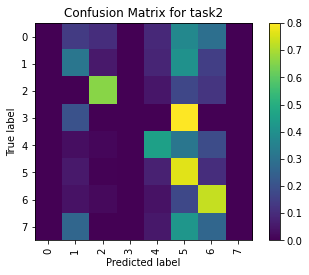

In [23]:
# Copied from https://blog.csdn.net/kane7csdn/article/details/83756583
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

labels_name = [label_map[inverse_map[i]] for i in range(num_classes)]
all_labels = [ int(d['label']) for d in test_set]
def plot_confusion_matrix(cm, labels_name, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]   
    plt.imshow(cm, interpolation='nearest')    
    plt.title(title)    
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))
    plt.xticks(num_local, labels_name, rotation=90)   
    plt.yticks(num_local, labels_name)  
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm = confusion_matrix(all_labels, predictions)
plot_confusion_matrix(cm, [str(x) for x in range(num_classes)], 'Confusion Matrix for {}'.format(task))

In [24]:
print(cm[:, 0])

[0 0 0 0 0 0 0 0]


In [25]:
count = {v: {'label': 0, 'pred': 0, 'tp': 0} for _, v in label_map.items()}

for cnt, (example, pred) in enumerate(zip(test_set, predictions)):
    
    label = example['label']
    # pred = inverse_map[pred]
    count[label]['label'] += 1
    count[pred]['pred'] += 1
    if label == pred:
        count[label]['tp'] += 1

In [27]:
tf1 = 0
tpre = 0
trec = 0
for k, s in count.items():
    print(k)
    recall = s['tp'] / (s['label'] + 0.0001)
    precision = s['tp'] / (s['pred'] + 0.0001)
    f1 = 2 * precision * recall / (recall + precision + 0.0001)
    tf1 += f1
    tpre += precision
    trec += recall
    print(f"F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
print("Average precision: {}".format(tpre / len(count)))
print("Average f1 score: {}".format(tf1 / len(count)))
print("Average recall: {}".format(trec/ len(count)))


0
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
1
F1: 0.3937, Precision: 0.5291, Recall: 0.3135
2
F1: 0.4695, Precision: 0.3649, Recall: 0.6585
3
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
4
F1: 0.5806, Precision: 0.8071, Recall: 0.4535
5
F1: 0.5783, Precision: 0.4657, Recall: 0.7630
6
F1: 0.5573, Precision: 0.4509, Recall: 0.7294
7
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Average precision: 0.32721029903809673
Average f1 score: 0.32242370580483837
Average recall: 0.3647345405164734


1
F1: 0.8132, Precision: 0.7260, Recall: 0.9243
0
F1: 0.5691, Precision: 0.7873, Recall: 0.4456

0
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
1
F1: 0.3937, Precision: 0.5291, Recall: 0.3135
2
F1: 0.4695, Precision: 0.3649, Recall: 0.6585
3
F1: 0.0000, Precision: 0.0000, Recall: 0.0000
4
F1: 0.5806, Precision: 0.8071, Recall: 0.4535
5
F1: 0.5783, Precision: 0.4657, Recall: 0.7630
6
F1: 0.5573, Precision: 0.4509, Recall: 0.7294
7
F1: 0.0000, Precision: 0.0000, Recall: 0.0000